In [18]:
## Put libraries to be used here

import decimal
import pandas as pd
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
import quandl
# API configuration here
quandl.ApiConfig.api_key = "VAA5bZ67DimoDkvMStuG"
solvers.options['show_progress'] = False

# libs for visualization
import matplotlib.pyplot as plt

In [19]:
## 1. List of stock tickers 

stocks1 = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB']
stocks2 = ['TIVO', 'JCP', 'F']

Minimal_gewicht1 = -0.0
Maximal_gewicht1 = 1.0
Minimal_gewicht2 = -0.0
Maximal_gewicht2 = 1.0
Scale = 100 
Riskaversion = 99 
rf = 0.01

target = 0.10

In [20]:
## 2. Getting Data for the stock tickers 

def datafunction(tickers):
    data = quandl.get_table('WIKI/PRICES', ticker = tickers, 
                            qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
                            date = { 'gte': '2017-11-31', 'lte': '2017-12-31' }, 
                            paginate=True)
    new = data.set_index('date')
    # use pandas pivot function to sort adj_close by tickers
    clean_data = new.pivot(columns='ticker')
    return clean_data

stocklist = stocks1 + stocks2
#stocklist = stocklist.sort()
clean_data = datafunction(stocklist)


## 3. Transforming Data for optimization 

returnss = (clean_data.pct_change().dropna())
number = len(stocklist)
returns = returnss.values #as_matrix()


## 4. Optimization!

def optimal_portfolio(returns):
    
    n = len(returns)
    N1 = len(stocks1)
    N2 = len(stocks2)
    returns = np.asmatrix(returns)
    
    #G = Scale
    #mus = [10**(5.0 * t/G - 1.0) for t in range(G)]
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    N=Scale
    mus_min=max(min(pbar),0)
    mus_max=max(pbar)
    mus_step=(mus_max - mus_min) / (N-1)
    mus = [mus_min + i*mus_step for i in range(N)]

    S = opt.matrix(np.cov(returns))
    #pbar = opt.matrix(np.mean(returns, axis=1))
    
    #constraint matrices
    dank = -np.array(np.eye(n))
    dabbie = np.array(np.eye(n))
    #ye = np.vstack((dank, dabbie))
    
    dd = np.concatenate((-np.transpose(pbar), dank),0)
    mm = np.concatenate((np.transpose(pbar), dabbie),0)
    ye = np.vstack((dd, mm))
    G = opt.matrix(ye, tc='d')
    
    #G = opt.matrix(np.concatenate((-np.transpose(pbar),ye),0))
    #G = opt.matrix(ye, tc='d')
    
    d1 = -np.ones((N1,1))*Minimal_gewicht1 
    e1 = np.ones((N1,1))*Maximal_gewicht1
    d2 = -np.ones((N2,1))*Minimal_gewicht2
    e2 =  np.ones((N2,1))*Maximal_gewicht2
    min_constraint = np.vstack((d1, d2))
    max_constraint = np.vstack((e1, e2))
    dodo = np.vstack((min_constraint, max_constraint))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    """
    """
    portfolios=[]
    for r_min in mus:
        eee = np.vstack((-np.ones((1,1))*r_min, min_constraint))
        fff = np.vstack((np.ones((1,1))*r_min, max_constraint))
        h = opt.matrix(np.concatenate((eee, fff),0))
        
        #h = opt.matrix(np.concatenate((-np.ones((1,1))*r_min, dodo),0))
        
        sol = solvers.qp(S, -pbar, G, h, A, b)['x']
        portfolios.append(sol)
    
    
    # Calculate target return portfolio
    """
    eee = np.vstack((-np.ones((1,1))*target, min_constraint))
    fff = np.vstack((np.ones((1,1))*target, max_constraint))
    h = opt.matrix(np.concatenate((eee, fff),0))
    portfolios = [solvers.qp(S, -pbar, G, h, A, b)['x']]
    
    """
   
    # CALCULATE RISKS AND RETURNS FOR FRONTIER  (will add back later)
    returns = np.asarray([blas.dot(pbar, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, S*x)) for x in portfolios])
    
    
    """
    # Maximum Return Portfolio (will always return weights with 100% in asset with maximum mean return)
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt((m1[2])/ m1[0])
    maxr_opt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
        """
    
    # approximates the position of the maximum Sharpe portfolio (also called tangent portfolio)
    # the bigger the scale parameter the more accurate the calculation of the maximum sharpe portfolio!
    slope = (returns-(rf/252))/risks
    sharpe_opt = slope.argmax()

    
    return  returns, risks, portfolios, G, h, mus, sharpe_opt

exp_returns, exp_risk, weights, G, h, mus, sharpe = optimal_portfolio(returns.T)


#index portfolios on the efficient frontier here
test1=np.array(opt.matrix(weights))
sublist=[test1[n:n+number] for n in range(0,len(test1),number)]
real=sublist[Riskaversion]

In [34]:
t = np.matrix(weights[99])
print((t).round(3))



[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


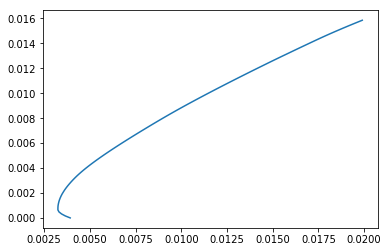

In [35]:
plt.plot(exp_risk, exp_returns)

In [36]:
w = exp_returns[99]

In [37]:
print(w*100)

1.585603907653684


In [38]:
print(stocklist)

['ALB', 'AMAT', 'AMD', 'CHK', 'F', 'FCX', 'HPE', 'IDXX', 'JCP', 'NEM', 'NVDA', 'OKE', 'TIVO', 'WMB']


In [39]:
t = returnss.mean()
print((t))

           ticker
adj_close  ALB      -0.001660
           AMAT     -0.000649
           AMD      -0.001874
           CHK      -0.001253
           F        -0.000351
           FCX       0.015856
           HPE      -0.000223
           IDXX      0.000517
           JCP      -0.002420
           NEM       0.000549
           NVDA     -0.000934
           OKE       0.001373
           TIVO     -0.005398
           WMB       0.002147
dtype: float64


In [40]:
l = np.array(stocklist)
dic = {}
for i in range(len(stocklist)):
    dic[stocklist[i]] = real[i]

indexlist = pd.Series(dic, index=stocklist)
newlist = indexlist[abs(indexlist) > 0.005]
newlist=newlist.astype(float)

In [41]:
stocklist1 = sorted(stocklist)